In [1]:
import grapher

In [2]:
import numpy as np
import pandas as pd
import cv2
import networkx as nx

In [3]:
df = pd.read_csv('object_map.csv')
img = cv2.imread('deskew.jpg', 0)

In [4]:
tree = grapher.ObjectTree()
tree.read(df, img)

graph_dict, text_list = tree.connect(plot=True, export_df=True)

print(graph_dict)
print('\n--------------------------------------------------------------\n')

print(text_list)
print('\n--------------------------------------------------------------\n')



{0: [1], 1: [7], 2: [4], 3: [1], 4: [6], 5: [8], 6: [7], 7: [11], 8: [23], 9: [10], 10: [11], 11: [30], 12: [13], 13: [15], 14: [15], 15: [17], 16: [17], 17: [19], 18: [19], 19: [28], 20: [21], 21: [22], 22: [23], 23: [25], 24: [25], 25: [26], 26: [27], 27: [28], 28: [29], 29: [30], 30: [39], 31: [32], 32: [33], 33: [34], 34: [38], 35: [36], 36: [37], 37: [38], 38: [39], 39: [44], 40: [41], 41: [42], 42: [43], 43: [44], 44: [49], 45: [46], 46: [47], 47: [48], 48: [49], 49: [52], 50: [51], 51: [52]}

--------------------------------------------------------------

['PO Box 3149', 'Invoice', 'CIL', 'Canyon Lake, TX 78133', '830-935-4430 Phone', 'INDUSTRIAL SERVICES INC.', 'Date', 'Invoice #', '830-935-4048 FAX', 'SPECIALIZING IN SOLUTIONS', '9/13/2019', '12379', 'Bill To', 'Ship To', 'Appleton Group', 'Appleton Group', 'Attn: Accounts Payable', '13639 Aldine Westfield Road', '9377 West Higgins', 'Houston, TX 77039', 'Rosemont, IL 60018', 'Need to email invoices', 'Customer Phone', '800-62

C:\Users\Sidsavi\Anaconda3\lib\site-packages\pandas\core\indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [5]:
G = nx.from_dict_of_lists(graph_dict)

In [6]:
adj_sparse = nx.adjacency_matrix(G)

In [7]:
# preprocess the sparse adjacency matrix returned by networkx function
A = np.array(adj_sparse.todense())


In [8]:
def _pad_adj(adj):
    '''
        This method resizes the input Adjacency matrix to shape 
        (self.max_nodes, self.max_nodes)

        adj: 
            2d numpy array
            adjacency matrix
    '''

    assert adj.shape[0] == adj.shape[1], f'The input adjacency matrix is \
        not square and has shape {adj.shape}'

    # get n of nxn matrix
    n = adj.shape[0]

    if n < max_nodes:
        target = np.zeros(shape=(max_nodes, max_nodes))

        # fill in the target matrix with the adjacency
        target[:adj.shape[0], :adj.shape[1]] = adj

    elif n > max_nodes:
        # cut away the excess rows and columns of adj
        target = adj[:max_nodes, :max_nodes]

    else:
        # do nothing
        target = adj

    return target

In [9]:
A

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [10]:
max_nodes = 50

In [11]:
A = _pad_adj(A)

In [12]:
A

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [13]:
def _get_text_features(data): 

    '''
        Args:
            str, input data

        Returns: 
            np.array, shape=(22,);
            an array of the text converted to features

    '''

    assert type(data) == str, f'Expected type {str}. Received {type(data)}.'

    n_upper = 0
    n_lower = 0
    n_alpha = 0
    n_digits = 0
    n_spaces = 0
    n_numeric = 0
    n_special = 0
    number = 0
    special_chars = {'&': 0, '@': 1, '#': 2, '(': 3, ')': 4, '-': 5, '+': 6, 
                    '=': 7, '*': 8, '%': 9, '.':10, ',': 11, '\\': 12,'/': 13, 
                    '|': 14, ':': 15}

    special_chars_arr = np.zeros(shape=len(special_chars))    

    # character wise
    for char in data: 

        # for lower letters 
        if char.islower(): 
            n_lower += 1

        # for upper letters 
        if char.isupper(): 
            n_upper += 1

        # for white spaces
        if char.isspace():
            n_spaces += 1

        # for alphabetic chars
        if char.isalpha():
            n_alpha += 1

        # for numeric chars
        if char.isnumeric():
            n_numeric += 1

        # array for special chars
        if char in special_chars.keys():
            char_idx = special_chars[char]
            # put 1 at index
            special_chars_arr[char_idx] += 1

    # word wise
    for word in data.split():

        # if digit is integer 
        try:
            number = int(word)
            n_digits += 1
        except:
            pass

        # if digit is float
        if n_digits == 0:
            try:
                number = float(word)
                n_digits += 1
            except:
                pass

    features = []
    features.append([n_lower, n_upper, n_spaces, n_alpha, n_numeric, n_digits])
    features = np.array(features)
    features = np.append(features, np.array(special_chars_arr))

    return features


def _pad_text_features(feat_arr):
    '''
        This method pads the feature matrix to size 
        (self.max_nodes, feat_arr.shape[1])
    '''
    target = np.zeros(shape=(max_nodes, feat_arr.shape[1]))

    if max_nodes > feat_arr.shape[0]:
        target[:feat_arr.shape[0], :feat_arr.shape[1]] = feat_arr

    elif max_nodes < feat_arr.shape[0]:
        target = feat_arr[:max_nodes, (feat_arr.shape[1]-1)]

    else: 
        target = feat_arr

    return target

In [14]:
# preprocess the list of text entities
feat_list = list(map(_get_text_features, text_list))

In [15]:
feat_arr = np.array(feat_list)


In [16]:
feat_arr[:50,21]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
X = _pad_text_features(feat_arr)

In [18]:
pd.DataFrame(X)

0
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0
5   0.0
6   0.0
7   0.0
8   0.0
9   0.0
10  0.0
11  0.0
12  0.0
13  0.0
14  0.0
15  0.0
16  1.0
17  0.0
18  0.0
19  0.0
20  0.0
21  0.0
22  0.0
23  0.0
24  0.0
25  0.0
26  0.0
27  0.0
28  0.0
29  0.0
30  0.0
31  0.0
32  0.0
33  0.0
34  0.0
35  0.0
36  0.0
37  0.0
38  0.0
39  0.0
40  0.0
41  0.0
42  0.0
43  0.0
44  0.0
45  0.0
46  0.0
47  0.0
48  0.0
49  0.0

In [19]:
pd.DataFrame(A)

0   1   2   3   4   5   6   7   8   9  ...  40  41  42  43  44  45  46  \
0    0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
1    1   0   0   1   0   0   0   1   0   0 ...   0   0   0   0   0   0   0   
2    0   0   0   0   1   0   0   0   0   0 ...   0   0   0   0   0   0   0   
3    0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
4    0   0   1   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
5    0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   0   0   0   
6    0   0   0   0   1   0   0   1   0   0 ...   0   0   0   0   0   0   0   
7    0   1   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
8    0   0   0   0   0   1   0   0   0   0 ...   0   0   0   0   0   0   0   
9    0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
10   0   0   0   0   0   0   0   0   0   1 ...   0   0   0   0   0   0   0   
11   0   0   0   0   0   0   0   1   0   0 ...   0   0   0   0   0   0   0   
12   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
13   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
14   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
15   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
16   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
17   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
18   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
19   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
20   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
21   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
22   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
23   0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   0   0   0   
24   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
25   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
26   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
27   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
28   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
29   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
30   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
31   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
32   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
33   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
34   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
35   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
36   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
37   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
38   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
39   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   0   0   
40   0   0   0   0   0   0   0   0   0   0 ...   0   1   0   0   0   0   0   
41   0   0   0   0   0   0   0   0   0   0 ...   1   0   1   0   0   0   0   
42   0   0   0   0   0   0   0   0   0   0 ...   0   1   0   1   0   0   0   
43   0   0   0   0   0   0   0   0   0   0 ...   0   0   1   0   1   0   0   
44   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   1   0   0   0   
45   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   1   
46   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   1   0   
47   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   1   
48   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
49   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   0   0   

    47  48  49  
0    0  

In [20]:
import matplotlib.pyplot as plt
#import networkx as nx

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=50)
    plt.show()
    return gr



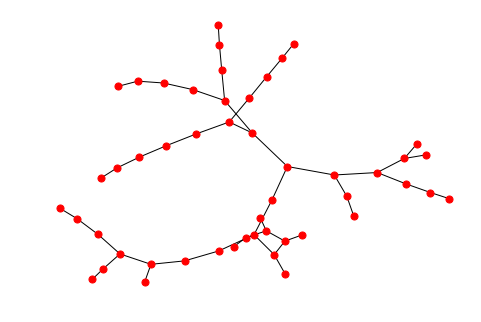

In [21]:
gra = show_graph_with_labels(A)

In [22]:
pwd()

'C:\\Users\\Sidsavi\\Geometric DL\\Graph-Convolution-on-Structured-Documents-master'

In [23]:
nx.write_gexf(gra,'gra.gexf')

In [24]:
print(nx.info(gra))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 49
Average degree:   1.9600


In [25]:
A

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [26]:
feat_list

[array([2., 3., 2., 5., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([6., 1., 0., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([0., 3., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([ 8.,  4.,  3., 12.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 4.,  1.,  1.,  5., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0., 21.,  2., 21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([3., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([6., 1., 1., 7., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([ 0.,  3.,  1.,  3., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0., 

In [27]:
len(text_list)

53

In [28]:
listed = text_list[0:50]

In [29]:
len(listed)

50

In [30]:
Adjace = pd.DataFrame(A, columns=listed, index=listed)

In [31]:
Adjace

PO Box 3149  Invoice  CIL  \
PO Box 3149                             0        1    0   
Invoice                                 1        0    0   
CIL                                     0        0    0   
Canyon Lake, TX 78133                   0        1    0   
830-935-4430 Phone                      0        0    1   
INDUSTRIAL SERVICES INC.                0        0    0   
Date                                    0        0    0   
Invoice #                               0        1    0   
830-935-4048 FAX                        0        0    0   
SPECIALIZING IN SOLUTIONS               0        0    0   
9/13/2019                               0        0    0   
12379                                   0        0    0   
Bill To                                 0        0    0   
Ship To                                 0        0    0   
Appleton Group                          0        0    0   
Appleton Group                          0        0    0   
Attn: Accounts Payable                  0        0    0   
13639 Aldine Westfield Road             0        0    0   
9377 West Higgins                       0        0    0   
Houston, TX 77039                       0        0    0   
Rosemont, IL 60018                      0        0    0   
Need to email invoices                  0        0    0   
Customer Phone                          0        0    0   
800-621-1506                            0        0    0   
Customer Fax                            0        0    0   
2817743755                              0        0    0   
P.O. Number                             0        0    0   
Terms                                   0        0    0   
Ship                                    0        0    0   
Via                                     0        0    0   
F.O.B.                                  0        0    0   
240100319949                            0        0    0   
Net 30                                  0        0    0   
9/11/2019                               0        0    0   
delivered                               0        0    0   
Quantity                                0        0    0   
Item Code                               0        0    0   
Description                             0        0    0   
Price Each                              0        0    0   
Amount                                  0        0    0   
10                                      0        0    0   
Industrial Adhesi                       0        0    0   
Coremaster FD CM30 12/Carton            0        0    0   
106.20                                  0        0    0   
1,062.00                                0        0    0   
1                                       0        0    0   
Freight Cost Inc                        0        0    0   
Freight                                 0        0    0   
66.00                                   0        0    0   
66.00                                   0        0    0   

                              Canyon Lake, TX 78133  830-935-4430 Phone  \
PO Box 3149                                       0                   0   
Invoice                                           1                   0   
CIL                                               0                   1   
Canyon Lake, TX 78133                             0                   0   
830-935-4430 Phone                                0                   0   
INDUSTRIAL SERVICES INC.                          0                   0   
Date                                              0                   1   
Invoice #                                         0                   0   
830-935-4048 FAX                                  0                   0   
SPECIALIZING IN SOLUTIONS                         0                   0   
9/13/2019                                         0                   0   
12379                                             0                   0   
Bill To                                      

In [32]:
Adjace['Customer Fax']

PO Box 3149                     0
Invoice                         0
CIL                             0
Canyon Lake, TX 78133           0
830-935-4430 Phone              0
INDUSTRIAL SERVICES INC.        0
Date                            0
Invoice #                       0
830-935-4048 FAX                0
SPECIALIZING IN SOLUTIONS       0
9/13/2019                       0
12379                           0
Bill To                         0
Ship To                         0
Appleton Group                  0
Appleton Group                  0
Attn: Accounts Payable          0
13639 Aldine Westfield Road     0
9377 West Higgins               0
Houston, TX 77039               0
Rosemont, IL 60018              0
Need to email invoices          0
Customer Phone                  0
800-621-1506                    0
Customer Fax                    0
2817743755                      1
P.O. Number                     0
Terms                           0
Ship                            0
Via           

In [33]:
Adjace['P.O. Number']

PO Box 3149                     0
Invoice                         0
CIL                             0
Canyon Lake, TX 78133           0
830-935-4430 Phone              0
INDUSTRIAL SERVICES INC.        0
Date                            0
Invoice #                       0
830-935-4048 FAX                0
SPECIALIZING IN SOLUTIONS       0
9/13/2019                       0
12379                           0
Bill To                         0
Ship To                         0
Appleton Group                  0
Appleton Group                  0
Attn: Accounts Payable          0
13639 Aldine Westfield Road     0
9377 West Higgins               0
Houston, TX 77039               0
Rosemont, IL 60018              0
Need to email invoices          0
Customer Phone                  0
800-621-1506                    0
Customer Fax                    0
2817743755                      1
P.O. Number                     0
Terms                           1
Ship                            0
Via           

In [34]:
Adjace['Terms']

PO Box 3149                     0
Invoice                         0
CIL                             0
Canyon Lake, TX 78133           0
830-935-4430 Phone              0
INDUSTRIAL SERVICES INC.        0
Date                            0
Invoice #                       0
830-935-4048 FAX                0
SPECIALIZING IN SOLUTIONS       0
9/13/2019                       0
12379                           0
Bill To                         0
Ship To                         0
Appleton Group                  0
Appleton Group                  0
Attn: Accounts Payable          0
13639 Aldine Westfield Road     0
9377 West Higgins               0
Houston, TX 77039               0
Rosemont, IL 60018              0
Need to email invoices          0
Customer Phone                  0
800-621-1506                    0
Customer Fax                    0
2817743755                      0
P.O. Number                     1
Terms                           0
Ship                            1
Via           

In [35]:
Adjace['F.O.B.']

PO Box 3149                     0
Invoice                         0
CIL                             0
Canyon Lake, TX 78133           0
830-935-4430 Phone              0
INDUSTRIAL SERVICES INC.        0
Date                            0
Invoice #                       0
830-935-4048 FAX                0
SPECIALIZING IN SOLUTIONS       0
9/13/2019                       0
12379                           1
Bill To                         0
Ship To                         0
Appleton Group                  0
Appleton Group                  0
Attn: Accounts Payable          0
13639 Aldine Westfield Road     0
9377 West Higgins               0
Houston, TX 77039               0
Rosemont, IL 60018              0
Need to email invoices          0
Customer Phone                  0
800-621-1506                    0
Customer Fax                    0
2817743755                      0
P.O. Number                     0
Terms                           0
Ship                            0
Via           

In [36]:
nx.diameter(gra)

16

In [37]:
from networkx.algorithms import approximation as approx

In [44]:
approx.local_node_connectivity(gra,1,5)

1

In [42]:
gra